In [1]:
import numpy as np
import mesa
import matplotlib.pyplot as plt
from scipy.special import softmax
import random

In [2]:
def simple_dist(vals):
  total = np.sum(vals)

  for i in range(len(vals)):
    vals[i] = vals[i]/total

  return vals

In [3]:
class ModifiedGrid(mesa.space.MultiGrid):

    def __init__(self, width, height, torus):
        super().__init__(width, height, torus)

        self.pheromone_vals = np.zeros((height,width))

    def get_pheromone_val(self):
        return self.pheromone_vals

In [4]:
class AntModel(mesa.Model):
    
    def __init__(self,n):
        super().__init__()
        self.num_agents = n
        self.grid = ModifiedGrid(50, 500, True)
        #self.init_cell_values()
        self.schedule = mesa.time.BaseScheduler(self)
        
        #subtraction of 0.01 from pheromones before each ant enters
        """for i in range(self.grid.pheromone_vals.shape[0]):
          for j in range(self.grid.pheromone_vals.shape[1]):
            if self.grid.pheromone_vals[i][j]-0.01 < 0:
              self.grid.pheromone_vals[i][j] = 0
            else:
              self.grid.pheromone_vals[i][j] -= 0.01"""

        for i in range(n):
          a = AntAgent(i, self)
          self.schedule.add(a)
          x = random.randint(0,self.grid.width-1)
          self.grid.place_agent(a, (x,0))
          #self.grid.pheromone_vals[0][x] += 1.0


    def step(self):
        self.schedule.step()
    
class AntAgent(mesa.Agent):
    
    def __init__(self, id, model):
        super().__init__(id, model)
    
    def move(self):
        possible_steps = self.get_possible_steps()
        new_position = self.choose_next_pos(possible_steps)
        self.model.grid.pheromone_vals[self.pos[1]][self.pos[0]] += 1.0 #leaves pheromone before moving to the next cell
        self.model.grid.move_agent(self, new_position)
        
    def get_possible_steps(self):
        x,y = self.pos
        pos_y = y + 1
        
        if x - 1 < 0:
            pos_x_1 = self.model.grid.width - 1
        else:
            pos_x_1 = x - 1
        
        pos_x_2 = x

        if x + 1 > 49:
            pos_x_3 = 0
        else:
            pos_x_3 = x + 1
        
        return [(pos_x_1, pos_y),(pos_x_2, pos_y),(pos_x_3, pos_y)]
        
    def choose_next_pos(self, possible_steps):
        #normalisation to be added
        ps1, ps2, ps3 = possible_steps 
        """normalised_pheromones = softmax([self.model.grid.pheromone_vals[ps1[1]][ps1[0]]+0.1,
                                         self.model.grid.pheromone_vals[ps2[1]][ps2[0]]+0.1,
                                         self.model.grid.pheromone_vals[ps3[1]][ps3[0]]+0.1])
        """
        """normalised_pheromones = get_probs([self.model.grid.pheromone_vals[ps1[1]][ps1[0]]+0.1,
                                         self.model.grid.pheromone_vals[ps2[1]][ps2[0]]+0.1,
                                         self.model.grid.pheromone_vals[ps3[1]][ps3[0]]+0.1])"""

        normalised_pheromones = simple_dist([self.model.grid.pheromone_vals[ps1[1]][ps1[0]]+0.1,
                                         self.model.grid.pheromone_vals[ps2[1]][ps2[0]]+0.1,
                                         self.model.grid.pheromone_vals[ps3[1]][ps3[0]]+0.1])


        if normalised_pheromones[0] == normalised_pheromones[1] == normalised_pheromones[2]:
            next_pos = possible_steps[random.choice([0,1,2])]
        else:
            #next_pos = possible_steps[np.argmax(normalised_pheromones)]
            next_pos = random.choices(possible_steps, normalised_pheromones)[0]


        return next_pos
    
    def step(self):
        self.move()

In [16]:
def reward_func(model, reward_history, _lambda=2.0):
  for cell in model.grid.coord_iter():
    content, x, y = cell
    
    if content != [] and y == 499:
      agents_last_pos = (x, y) #-> x,y represents axis

  if agents_last_pos[0] in range(19,32):
    score = 1
  else:
    score = 0

  reward = reward_history[-1] + (score - reward_history[-1])/_lambda

  return reward

def decay(reward, pheromone_vals):
  decay_factor = 1 - (1/(495*reward+5))
  return pheromone_vals*decay_factor

In [6]:
def subtraction(pheromone_vals):
  pheromone_vals -= 0.01
  for i in range(pheromone_vals.shape[0]):
    for j in range(pheromone_vals.shape[1]):
      if pheromone_vals[i][j] < 0:
        pheromone_vals[i][j] = 0
  return pheromone_vals

In [7]:
def run_simulation(num_iterations=10000, num_agents=1, _lambda=2.0):
  model = AntModel(1)
  for i in range(499):
      model.step()
  reward_history = [0]

  pheromone_data = []
  for iteration in range(1,num_iterations+1):
    pheromone_vals = model.grid.get_pheromone_val()
    reward = reward_func(model, reward_history, _lambda)
    reward_history.append(reward)
    pheromone_vals = decay(reward, pheromone_vals)
    model = AntModel(1)
    pheromone_vals = subtraction(pheromone_vals)
    model.grid.pheromone_vals = pheromone_vals
    for i in range(499):
      model.step()
    if iteration == 1:
      pheromone_data.append(model.grid.pheromone_vals)
    if iteration == 100:
      pheromone_data.append(model.grid.pheromone_vals)
    elif iteration%1000 == 0:
      pheromone_data.append(model.grid.pheromone_vals)
  return pheromone_data

In [8]:
def draw_graphs(pheromone_data):
  fig,axs = plt.subplots(1,6, figsize=(15,10))
  axs[0].imshow(pheromone_data[0], interpolation="nearest")
  axs[0].set_xticks([19,32])
  axs[1].imshow(pheromone_data[1], interpolation="nearest")
  axs[1].set_xticks([19,32])
  axs[2].imshow(pheromone_data[2], interpolation="nearest")
  axs[2].set_xticks([19,32])

  axs[3].imshow(pheromone_data[3], interpolation="nearest")
  axs[3].set_xticks([19,32])
  axs[4].imshow(pheromone_data[4], interpolation="nearest")
  axs[4].set_xticks([19,32])
  axs[5].imshow(pheromone_data[-1], interpolation="nearest")
  axs[5].set_xticks([19,32])

  for col in range(6):
    for row in range(1):
      ax = axs[col]
      pcm = ax.pcolormesh(pheromone_data[col])
      fig.colorbar(pcm, ax=ax)


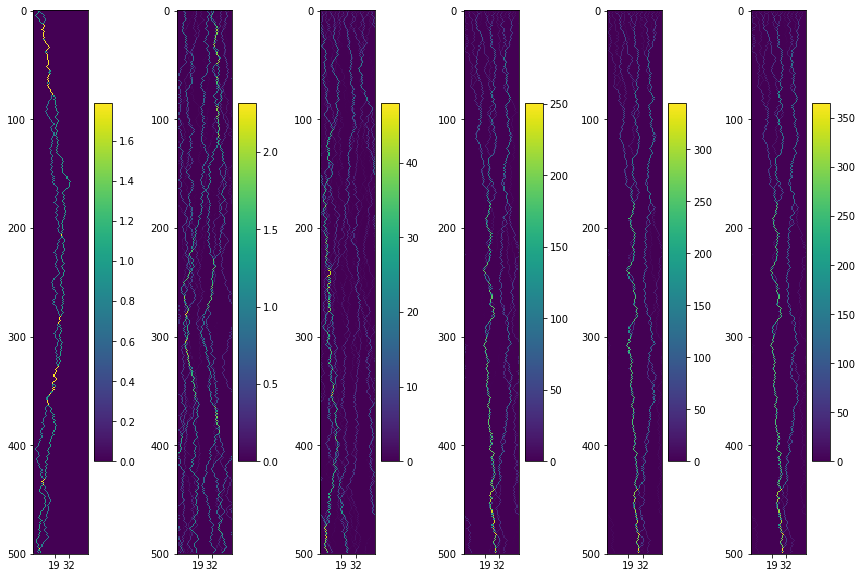

In [20]:
data_0 = run_simulation(num_iterations=4000, _lambda=2.0)
draw_graphs(data_0)

In [ ]:
!git push